In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge

In [2]:
df_energy=pd.read_csv("energy_dataset.csv")
df_weather=pd.read_csv("weather_features.csv")

In [3]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
#drop all the columns that are formed by zeroes and NaNs

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead'], 
                            axis=1)

In [5]:
#remove the columns which will not be used at all in our analysis

df_energy = df_energy.drop(['total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)


In [6]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [7]:
df_energy.describe().round(1)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.0,35046.0,35046.0,35046.0,35045.0,35045.0,35045.0,35046.0,35047.0,35046.0,35046.0,35046.0,35045.0,35046.0,35028.0,35064.0,35064.0
mean,383.5,448.1,5622.7,4256.1,298.3,475.6,972.1,2605.1,6263.9,60.2,85.6,1432.7,269.5,5464.5,28696.9,49.9,57.9
std,85.4,354.6,2201.8,1961.6,52.5,792.4,400.8,1835.2,839.7,20.2,14.1,1680.1,50.2,3213.7,4575.0,14.6,14.2
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18041.0,2.1,9.3
25%,333.0,0.0,4126.0,2527.0,263.0,0.0,637.0,1077.2,5760.0,53.0,73.0,71.0,240.0,2933.0,24807.8,41.5,49.3
50%,367.0,509.0,4969.0,4474.0,300.0,68.0,906.0,2164.0,6566.0,57.0,88.0,616.0,279.0,4849.0,28901.0,50.5,58.0
75%,433.0,757.0,6429.0,5838.8,330.0,616.0,1250.0,3757.0,7025.0,80.0,97.0,2578.0,310.0,7398.0,32192.0,60.5,68.0
max,592.0,999.0,20034.0,8359.0,449.0,4523.0,2000.0,9728.0,7117.0,106.0,119.0,5792.0,357.0,17436.0,41015.0,102.0,116.8


In [8]:
df_energy.isna().sum()

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [9]:
# fill na cell with interpolation
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [10]:
# change index to date
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)

In [11]:
df_energy = df_energy.set_index('time')

In [12]:
df_energy

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,30653.0,68.85,77.02
2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,29735.0,68.40,76.16
2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,28071.0,66.88,74.30


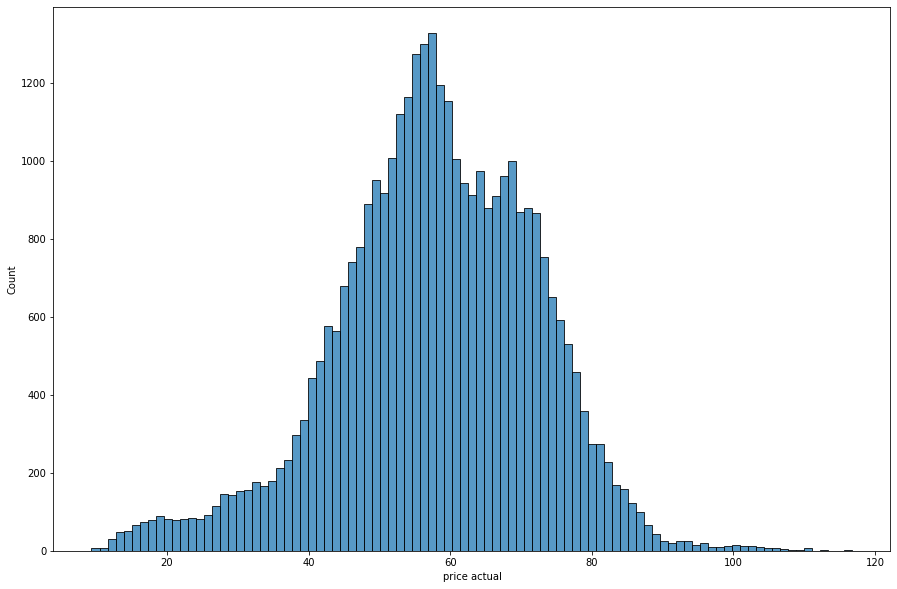

In [13]:
# distrubiton of actual price
plt.figure(figsize=(15,10))
sns.histplot(df_energy,x='price actual');


In [14]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


In [15]:
df_weather.isna().sum()

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [16]:
df_weather.dt_iso.duplicated().sum()

143332

In [17]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [18]:
df_weather.index=df_weather.index.strftime("%A %d %B %Y %H")

In [19]:
mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [20]:
#dummy variable provide same information
df_weather = df_weather.drop(['weather_id', 'weather_main',
                            'weather_icon'], 
                            axis=1)


In [21]:
# delete duplicate values
temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 9935 duplicate rows in df_weather based on all columns.


In [22]:
df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [23]:
print('There are {} observations in df_energy.'.format(df_energy.shape[0]))
cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [24]:
# strip city names
df_weather.iloc[:,0]= df_weather.iloc[:,0].str.strip()

In [25]:
df_Barcelona=df_weather[df_weather.city_name=="Barcelona"]
df_Bilbao=df_weather[df_weather.city_name=="Bilbao"]
df_Madrid=df_weather[df_weather.city_name=="Madrid"]
df_Seville=df_weather[df_weather.city_name=="Seville"]
df_Valencia=df_weather[df_weather.city_name=="Valencia"]

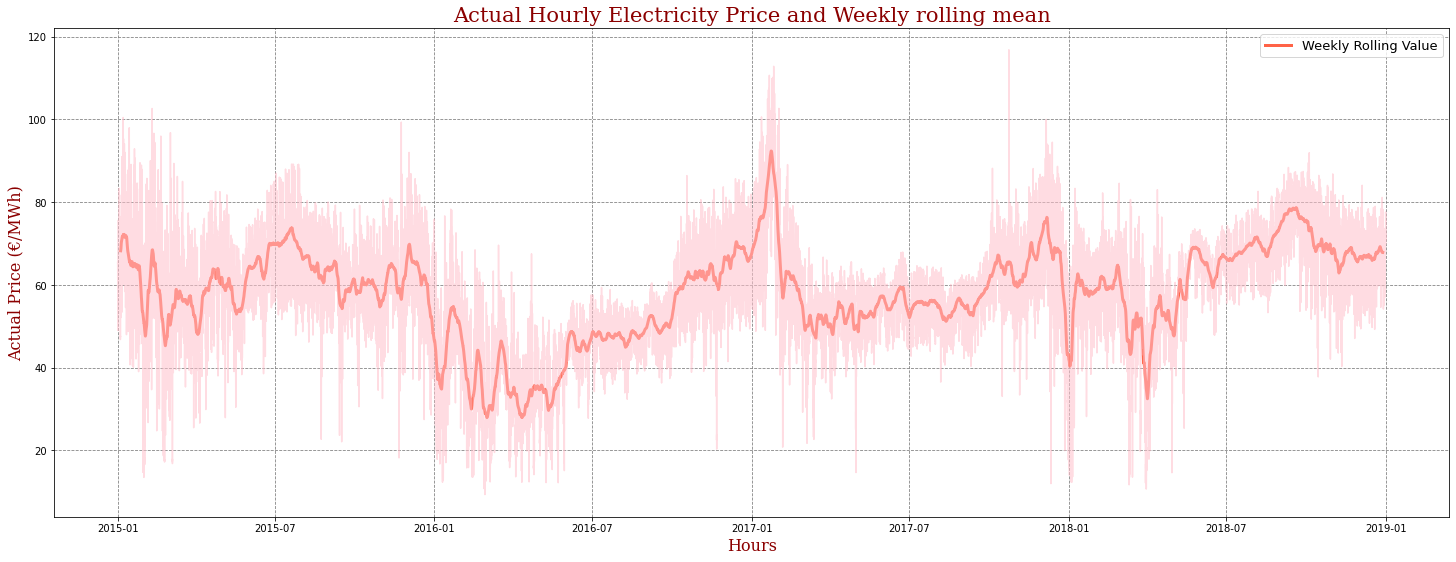

In [26]:
font = {'family':'serif','color':'darkred','size':21}
font1 = {'family':'serif','color':'darkred','size':16}
plt.figure(figsize=(25,9))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.8)
plt.xlabel("Hours" , fontdict = font1)
plt.ylabel("Actual Price (€/MWh)" , fontdict = font1)
plt.title("Actual Hourly Electricity Price and Weekly rolling mean", fontdict = font)
plt.plot(df_energy['price actual'].rolling(24*7, center=True).mean(),label="Weekly Rolling Value",linewidth=3,c="tomato")
plt.plot(df_energy['price actual'],c="pink",alpha=0.55)
plt.legend(prop={'size': 13})
plt.show()

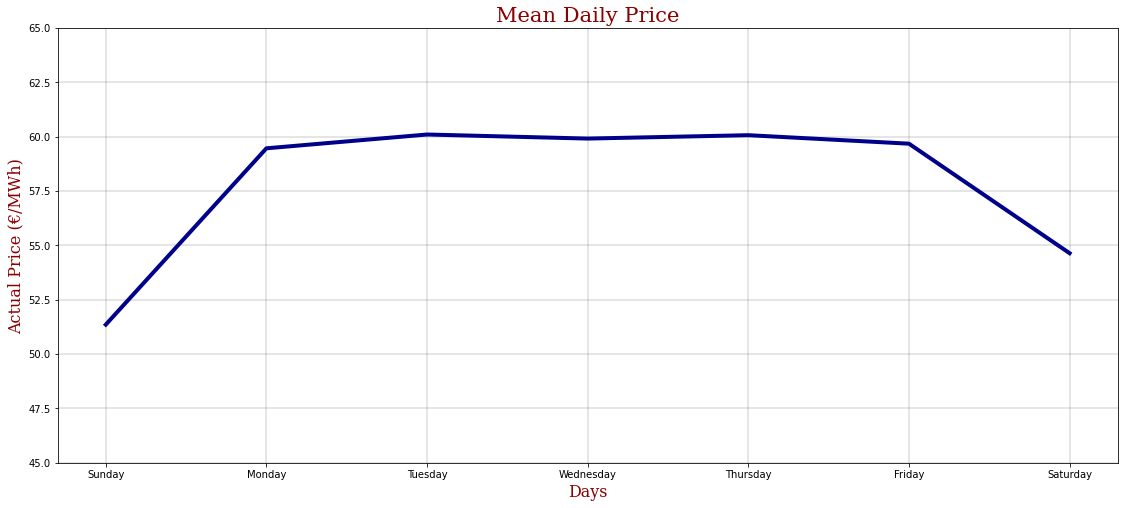

In [27]:
plt.figure(figsize=(19,8))
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.4)
plt.xlabel("Days" , fontdict = font1)
plt.ylabel("Actual Price (€/MWh)" , fontdict = font1)
plt.title("Mean Daily Price", fontdict = font)
plt.plot(df_energy.groupby(df_energy.index.strftime("%w"))["price actual"].mean(),linewidth=4,c="darkblue")
positions = (0,1,2,3,4,5,6)
labels = ('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday')
plt.xticks(positions,labels)
plt.ylim((45,65))
plt.show()

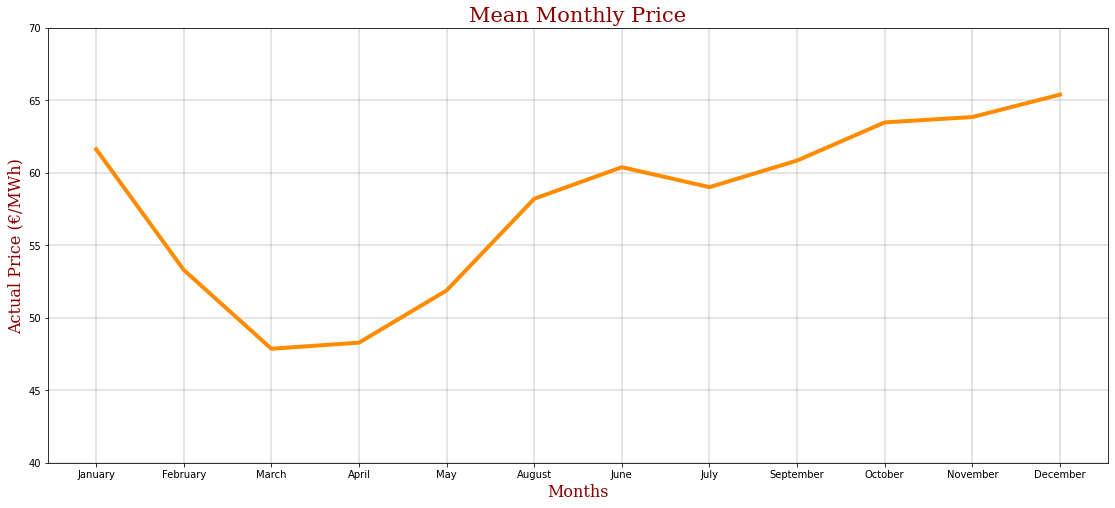

In [28]:
plt.figure(figsize=(19,8))
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.4)
plt.xlabel("Months" , fontdict = font1)
plt.ylabel("Actual Price (€/MWh)" , fontdict = font1)
plt.title("Mean Monthly Price", fontdict = font)
plt.plot(df_energy.groupby(df_energy.index.strftime("%m"))["price actual"].mean(),linewidth=4,c="darkorange")
positions = (0,1,2,3,4,5,6,7,8,9,10,11)
labels = ('January','February','March','April','May','August','June','July','September','October','November','December')
plt.xticks(positions, labels)
plt.ylim((40,70))
plt.show()

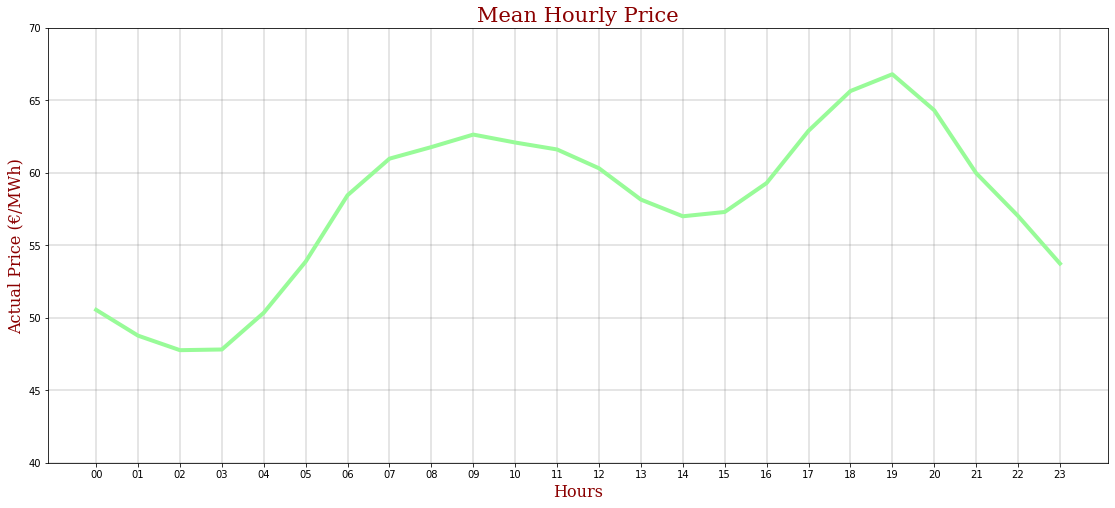

In [29]:
plt.figure(figsize=(19,8))
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.4)
plt.xlabel("Hours" , fontdict = font1)
plt.ylabel("Actual Price (€/MWh)" , fontdict = font1)
plt.title("Mean Hourly Price", fontdict = font)
plt.plot(df_energy.groupby(df_energy.index.strftime("%H"))["price actual"].mean(),linewidth=4,c="palegreen")
plt.ylim((40,70))
plt.show()

In [30]:
# February, march ,april and may has lower price.
# Weekdays' price higher than weekends.
# During nights electricity price down.

In [31]:
df_energy["month"],df_energy["day"],df_energy["hour"] =1,1,1

In [32]:
for i in range(len(df_energy)):
    if df_energy.index[i].strftime("%H") in ("00","01","02","03","04","23"):
        df_energy.iloc[i,-1]=0
    if df_energy.index[i].strftime("%A") in ('Sunday','Saturday'):
        df_energy.iloc[i,-2]=0
    if df_energy.index[i].strftime("%B") in ('February','March','April','May'):
        df_energy.iloc[i,-3]=0        
        

In [33]:
df_energy.index=df_energy.index.strftime("%A %d %B %Y %H")

In [34]:
# Let's try to predict electric price of  Barcelona

In [35]:
df_Barcelona=df_Barcelona.join(pd.get_dummies(df_Barcelona["weather_description"]))
df_Barcelona.drop("weather_description",axis=1,inplace=True)


In [36]:
df_analysis_barcelona_energy= df_energy.join(df_Barcelona,how="inner")

In [37]:
X = df_analysis_barcelona_energy[df_analysis_barcelona_energy.columns.drop(['price actual','city_name'])].values
y = df_analysis_barcelona_energy['price actual'].values


In [38]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size=0.32 , random_state =25)

In [39]:
mlr=LinearRegression()
mlr.fit(x_train, y_train)
y_pred = mlr.predict(x_test)

Results of Multiple Linear Regression sklearn.metrics
MAE:       5.827
MSE:       65.883
RMSE:      8.117
R-Squared: 0.666


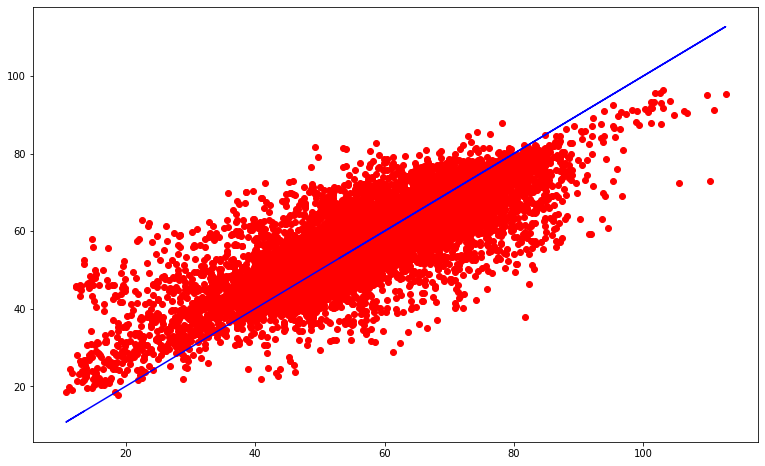

In [41]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  
r2 = metrics.r2_score(y_test,y_pred)

plt.figure(figsize=(13,8))
plt.scatter(y_test,y_pred,color='red')
plt.plot(y_test,y_test,color='blue')


print("Results of Multiple Linear Regression sklearn.metrics")
print("MAE:      ",round(mae,3))
print("MSE:      ", round(mse,3))
print("RMSE:     ", round(rmse,3))
print("R-Squared:", round(r2,3))